### Planning

- README is in a good position

### Acquisition

Need: 
- properties_2017: bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, fips, lotsizesquarefeet, taxvaluedollarcnt, yearbuilt, garagecarcnt, garagetotalsqft, transactiondate
- predictions_2017: join using parcelid
- propertylandusetype tables: join using 'propertylandusetypeid'

Let's get the env setup

In [1]:
from env import get_db_url
import os
import pandas as pd
import numpy as np

Make the get_zillow function (creates a csv)

In [2]:
def get_zillow():
    '''This function imports zillow 2017 data from MySql codeup server and creates a csv
    
    argument: df
    
    returns: zillow df'''
    filename = "zillow.csv"
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
    else:
        query = """
        SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, lotsizesquarefeet, fips, transactiondate, garagecarcnt, garagetotalsqft
        FROM properties_2017
        JOIN propertylandusetype USING (propertylandusetypeid)
        JOIN predictions_2017 USING (parcelid)
        WHERE propertylandusetypeid like '261';
        """
        connection = get_db_url("zillow")
        df = pd.read_sql(query, connection)
        df.to_csv(filename, index=False)
    return df

It works so copy this over to Wrangle

In [3]:
df = get_zillow()

In [4]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,lotsizesquarefeet,fips,transactiondate,garagecarcnt,garagetotalsqft
0,4.0,3.5,3100.0,1023282.0,1998.0,4506.0,6059.0,2017-01-01,2.0,633.0
1,2.0,1.0,1465.0,464000.0,1967.0,12647.0,6111.0,2017-01-01,1.0,0.0
2,3.0,2.0,1243.0,564778.0,1962.0,8432.0,6059.0,2017-01-01,2.0,440.0
3,4.0,3.0,2376.0,145143.0,1970.0,13038.0,6037.0,2017-01-01,NaN,NaN
4,4.0,3.0,2962.0,773303.0,1950.0,63000.0,6037.0,2017-01-01,NaN,NaN


In [5]:
df.shape

(52442, 10)

### Preparation

lets see what needs to be cleaned up

create a function to visualize whats in the dataset

In [3]:
def check_columns(df):
    """
    This function takes a pandas dataframe as input and returns
    a dataframe with information about each column in the dataframe. For
    each column, it returns the column name, the number of
    unique values in the column, the unique values themselves,
    the number of null values in the column, and the data type of the column.
    The resulting dataframe is sorted by the 'Number of Unique Values' column in ascending order.
​
    Args:
    - df: pandas dataframe
​
    Returns:
    - pandas dataframe
    """
    data = []
    # Loop through each column in the dataframe
    for column in df.columns:
        # Append the column name, number of unique values, unique values, number of null values, and data type to the data list
        data.append(
            [
                column,
                df[column].nunique(),
                df[column].unique(),
                df[column].isna().sum(),
                df[column].isna().mean(),
                df[column].dtype
            ]
        )
    # Create a pandas dataframe from the data list, with column names 'Column Name', 'Number of Unique Values', 'Unique Values', 'Number of Null Values', and 'dtype'
    # Sort the resulting dataframe by the 'Number of Unique Values' column in ascending order
    return pd.DataFrame(
        data,
        columns=[
            "Column Name",
            "Number of Unique Values",
            "Unique Values",
            "Number of Null Values",
            "Proportion of Null Values",
            "dtype"
        ],
    ).sort_values(by="Number of Unique Values")

In [7]:
check_columns(df)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
6,fips,3,"[6059.0, 6111.0, 6037.0]",0,0.000000,float64
0,bedroomcnt,14,"[4.0, 2.0, 3.0, 6.0, 5.0, 1.0, 7.0, 0.0, 8.0, ...",0,0.000000,float64
8,garagecarcnt,14,"[2.0, 1.0, nan, 3.0, 4.0, 5.0, 0.0, 7.0, 6.0, ...",34427,0.656478,float64
1,bathroomcnt,22,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ...",0,0.000000,float64
4,yearbuilt,133,"[1998.0, 1967.0, 1962.0, 1970.0, 1950.0, 1922....",116,0.002212,float64
7,transactiondate,258,"[2017-01-01, 2017-01-02, 2017-01-03, 2017-01-0...",0,0.000000,object
9,garagetotalsqft,839,"[633.0, 0.0, 440.0, nan, 420.0, 447.0, 485.0, ...",34427,0.656478,float64
2,calculatedfinishedsquarefeet,4723,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0...",82,0.001564,float64
5,lotsizesquarefeet,14292,"[4506.0, 12647.0, 8432.0, 13038.0, 63000.0, 42...",369,0.007036,float64
3,taxvaluedollarcnt,38942,"[1023282.0, 464000.0, 564778.0, 145143.0, 7733...",1,0.000019,float64


Need to rename columns to work with easier

- fips --> county
- bedroomcnt --> bedrooms
- garagecarcnt --> garage_fits
- bathroomcnt --> bathrooms
- garagetotalsqft --> garage_area
- calculatedfinishedsquarefeet --> finished_area
- lotsizesquarefeet --> lot_area
- taxvaluedollarcnt --> home_value

In [8]:
df.rename(columns={'fips': 'county', 'bedroomcnt': 'bedrooms', 'garagecarcnt': 'garage_fits', 'bathroomcnt': 'bathrooms', 'garagetotalsqft': 'garage_area', 'calculatedfinishedsquarefeet': 'finished_area', 'lotsizesquarefeet': 'lot_area', 'taxvaluedollarcnt': 'home_value'}, inplace=True)

In [9]:
df.head()

,bedrooms,bathrooms,finished_area,home_value,yearbuilt,lot_area,county,transactiondate,garage_fits,garage_area
0,4.0,3.5,3100.0,1023282.0,1998.0,4506.0,6059.0,2017-01-01,2.0,633.0
1,2.0,1.0,1465.0,464000.0,1967.0,12647.0,6111.0,2017-01-01,1.0,0.0
2,3.0,2.0,1243.0,564778.0,1962.0,8432.0,6059.0,2017-01-01,2.0,440.0
3,4.0,3.0,2376.0,145143.0,1970.0,13038.0,6037.0,2017-01-01,NaN,NaN
4,4.0,3.0,2962.0,773303.0,1950.0,63000.0,6037.0,2017-01-01,NaN,NaN


In [10]:
check_columns(df)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
6,county,3,"[6059.0, 6111.0, 6037.0]",0,0.000000,float64
0,bedrooms,14,"[4.0, 2.0, 3.0, 6.0, 5.0, 1.0, 7.0, 0.0, 8.0, ...",0,0.000000,float64
8,garage_fits,14,"[2.0, 1.0, nan, 3.0, 4.0, 5.0, 0.0, 7.0, 6.0, ...",34427,0.656478,float64
1,bathrooms,22,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ...",0,0.000000,float64
4,yearbuilt,133,"[1998.0, 1967.0, 1962.0, 1970.0, 1950.0, 1922....",116,0.002212,float64
7,transactiondate,258,"[2017-01-01, 2017-01-02, 2017-01-03, 2017-01-0...",0,0.000000,object
9,garage_area,839,"[633.0, 0.0, 440.0, nan, 420.0, 447.0, 485.0, ...",34427,0.656478,float64
2,finished_area,4723,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0...",82,0.001564,float64
5,lot_area,14292,"[4506.0, 12647.0, 8432.0, 13038.0, 63000.0, 42...",369,0.007036,float64
3,home_value,38942,"[1023282.0, 464000.0, 564778.0, 145143.0, 7733...",1,0.000019,float64


What do I see now?
- county: 
    - change unique values to (6037: 'LA', 6059: 'Orange', 6111: 'Ventura')
    - no nulls


In [11]:
# start with county, change unique values
df.county = df.county.map({6037: 'LA', 6059: 'Orange', 6111: 'Ventura'})

- bedrooms:
    - change type to int
    - drop 0 bedrooms
    - drop more than 8 bedrooms

In [12]:
df.bedrooms = df.bedrooms.astype(int)

In [13]:
df.bedrooms[df['bedrooms'] <= 8]

0        4
1        2
2        3
3        4
4        4
        ..
52437    2
52438    4
52439    3
52440    3
52441    3
Name: bedrooms, Length: 52427, dtype: int64

In [14]:
df.drop(df[df['bedrooms'] > 8].index, inplace=True)

In [15]:
df.bedrooms.value_counts()

bedrooms
3    23360
4    15240
2     8340
5     3973
6      635
1      612
0      137
7      106
8       24
Name: count, dtype: int64

In [16]:
df.drop(df[df['bedrooms'] == 0].index, inplace=True)

In [17]:
df.bedrooms.value_counts()

bedrooms
3    23360
4    15240
2     8340
5     3973
6      635
1      612
7      106
8       24
Name: count, dtype: int64

- garage_fits:
    - 65% nan (Assume they have No Garage?)
    - for nan, change value to 0.0
    - change type to int


In [18]:
# garage_fits change nan, dtype=int
df.garage_fits = df.garage_fits.fillna(0).astype(int)

- bathrooms:
    - looks good


- garage_area:
    - 65% nan (Assume the have No Garage?)
    - for nan, change value to 0.0


In [19]:
df.garage_area = df.garage_area.fillna(0)

In [20]:
df.garage_area.value_counts()

garage_area
0.0       34474
400.0       788
441.0       678
462.0       660
360.0       647
          ...  
1296.0        1
221.0         1
301.0         1
2198.0        1
957.0         1
Name: count, Length: 839, dtype: int64

- yearbuilt:
    - 0.02% nulls, drop null values
    - change type to datetime 'year'


In [21]:
check_columns(df)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
6,county,3,"[Orange, Ventura, LA]",0,0.000000,object
0,bedrooms,8,"[4, 2, 3, 6, 5, 1, 7, 8]",0,0.000000,int64
8,garage_fits,14,"[2, 1, 0, 3, 4, 5, 7, 6, 10, 8, 9, 11, 13, 14]",0,0.000000,int64
1,bathrooms,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ...",0,0.000000,float64
4,yearbuilt,133,"[1998.0, 1967.0, 1962.0, 1970.0, 1950.0, 1922....",40,0.000765,float64
7,transactiondate,258,"[2017-01-01, 2017-01-02, 2017-01-03, 2017-01-0...",0,0.000000,object
9,garage_area,839,"[633.0, 0.0, 440.0, 420.0, 447.0, 485.0, 446.0...",0,0.000000,float64
2,finished_area,4702,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0...",8,0.000153,float64
5,lot_area,14236,"[4506.0, 12647.0, 8432.0, 13038.0, 63000.0, 42...",353,0.006751,float64
3,home_value,38825,"[1023282.0, 464000.0, 564778.0, 145143.0, 7733...",1,0.000019,float64


- finished_area:
    - 0.01% null
    - drop null values


- lot_area:
    - 0.07% null
    - drop null values


- home_value:
    - 1 null
    - just drop it


In [22]:
check_columns(df)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
6,county,3,"[Orange, Ventura, LA]",0,0.000000,object
0,bedrooms,8,"[4, 2, 3, 6, 5, 1, 7, 8]",0,0.000000,int64
8,garage_fits,14,"[2, 1, 0, 3, 4, 5, 7, 6, 10, 8, 9, 11, 13, 14]",0,0.000000,int64
1,bathrooms,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ...",0,0.000000,float64
4,yearbuilt,133,"[1998.0, 1967.0, 1962.0, 1970.0, 1950.0, 1922....",40,0.000765,float64
7,transactiondate,258,"[2017-01-01, 2017-01-02, 2017-01-03, 2017-01-0...",0,0.000000,object
9,garage_area,839,"[633.0, 0.0, 440.0, 420.0, 447.0, 485.0, 446.0...",0,0.000000,float64
2,finished_area,4702,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0...",8,0.000153,float64
5,lot_area,14236,"[4506.0, 12647.0, 8432.0, 13038.0, 63000.0, 42...",353,0.006751,float64
3,home_value,38825,"[1023282.0, 464000.0, 564778.0, 145143.0, 7733...",1,0.000019,float64


In [23]:
# take care of null vals for yearbuilt, finished_area, lot_area, and home_value
df = df.dropna()

In [24]:
check_columns(df)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
6,county,3,"[Orange, Ventura, LA]",0,0.0,object
0,bedrooms,8,"[4, 2, 3, 6, 5, 1, 7, 8]",0,0.0,int64
8,garage_fits,14,"[2, 1, 0, 3, 4, 5, 7, 6, 10, 8, 9, 11, 13, 14]",0,0.0,int64
1,bathrooms,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ...",0,0.0,float64
4,yearbuilt,133,"[1998.0, 1967.0, 1962.0, 1970.0, 1950.0, 1922....",0,0.0,float64
7,transactiondate,258,"[2017-01-01, 2017-01-02, 2017-01-03, 2017-01-0...",0,0.0,object
9,garage_area,836,"[633.0, 0.0, 440.0, 420.0, 447.0, 485.0, 446.0...",0,0.0,float64
2,finished_area,4677,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0...",0,0.0,float64
5,lot_area,14222,"[4506.0, 12647.0, 8432.0, 13038.0, 63000.0, 42...",0,0.0,float64
3,home_value,38566,"[1023282.0, 464000.0, 564778.0, 145143.0, 7733...",0,0.0,float64


In [25]:
df.shape

(51895, 10)

- transactiondate:
    - type is object...consider changing into just month of transaction
    - only using predictions for the samples so drop column


In [26]:
df.drop(columns='transactiondate', inplace=True)

In [27]:
check_columns(df)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
6,county,3,"[Orange, Ventura, LA]",0,0.0,object
0,bedrooms,8,"[4, 2, 3, 6, 5, 1, 7, 8]",0,0.0,int64
7,garage_fits,14,"[2, 1, 0, 3, 4, 5, 7, 6, 10, 8, 9, 11, 13, 14]",0,0.0,int64
1,bathrooms,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ...",0,0.0,float64
4,yearbuilt,133,"[1998.0, 1967.0, 1962.0, 1970.0, 1950.0, 1922....",0,0.0,float64
8,garage_area,836,"[633.0, 0.0, 440.0, 420.0, 447.0, 485.0, 446.0...",0,0.0,float64
2,finished_area,4677,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0...",0,0.0,float64
5,lot_area,14222,"[4506.0, 12647.0, 8432.0, 13038.0, 63000.0, 42...",0,0.0,float64
3,home_value,38566,"[1023282.0, 464000.0, 564778.0, 145143.0, 7733...",0,0.0,float64


Overall, only lose .1% of data by dropping nulls

In [28]:
from env import get_db_url
import os
import pandas as pd
import numpy as np

Combine in a function for prep_zillow()

In [11]:
def prep_zillow(df):
    '''takes the zillow dataframe, drops nulls, drops transactiondate, changes column names, 
    and replaces null values in garage columns

    argument: df

    returns: clean_df
    '''
    # rename columns
    df.rename(columns={'fips': 'county', 'bedroomcnt': 'bedrooms', 'garagecarcnt': 'garage_fits', 'bathroomcnt': 'bathrooms', 'garagetotalsqft': 'garage_area', 'calculatedfinishedsquarefeet': 'finished_area', 'lotsizesquarefeet': 'lot_area', 'taxvaluedollarcnt': 'home_value'}, inplace=True)
    
    # garage_fits change nan, dtype=int, fill nulls for garage_area
    df.garage_fits = df.garage_fits.fillna(0).astype(int)
    df.garage_area = df.garage_area.fillna(0)
    
    # take care of null vals for yearbuilt, finished_area, lot_area, and home_value
    df.dropna(axis=0,inplace=True)
    # change yearbuilt type to int
    df.yearbuilt = df.yearbuilt.astype(int)
    # drop transactiondate
    df = df.drop(columns='transactiondate')
    # start with county, change unique values
    df.county = df.county.map({6037: 'LA', 6059: 'Orange', 6111: 'Ventura'})
    # change bedroom dtype to int and drop values 0 and everything above 8
    df['bedrooms'] = df.bedrooms.astype(int)
    df.drop(df[df['bedrooms'] > 8].index, inplace=True)
    df.drop(df[df['bedrooms'] == 0].index, inplace=True)
    
    return df

In [12]:
df = get_zillow()

In [13]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,lotsizesquarefeet,fips,transactiondate,garagecarcnt,garagetotalsqft
0,4.0,3.5,3100.0,1023282.0,1998.0,4506.0,6059.0,2017-01-01,2.0,633.0
1,2.0,1.0,1465.0,464000.0,1967.0,12647.0,6111.0,2017-01-01,1.0,0.0
2,3.0,2.0,1243.0,564778.0,1962.0,8432.0,6059.0,2017-01-01,2.0,440.0
3,4.0,3.0,2376.0,145143.0,1970.0,13038.0,6037.0,2017-01-01,NaN,NaN
4,4.0,3.0,2962.0,773303.0,1950.0,63000.0,6037.0,2017-01-01,NaN,NaN


In [14]:
df = prep_zillow(df)

In [10]:
df

,bedrooms,bathrooms,finished_area,home_value,yearbuilt,lot_area,county,garage_fits,garage_area
0,4.0,3.5,3100.0,1023282.0,1998,4506.0,Orange,2,633.0
1,2.0,1.0,1465.0,464000.0,1967,12647.0,Ventura,1,0.0
2,3.0,2.0,1243.0,564778.0,1962,8432.0,Orange,2,440.0
3,4.0,3.0,2376.0,145143.0,1970,13038.0,LA,0,0.0
4,4.0,3.0,2962.0,773303.0,1950,63000.0,LA,0,0.0
...,...,...,...,...,...,...,...,...,...
52437,2.0,2.0,1286.0,354621.0,1940,47405.0,LA,0,0.0
52438,4.0,2.0,1612.0,67205.0,1964,12105.0,Ventura,2,560.0
52439,3.0,1.0,1032.0,49546.0,1954,5074.0,LA,0,0.0
52440,3.0,2.0,1762.0,522000.0,1955,6347.0,LA,0,0.0


In [15]:
check_columns(df)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
6,county,3,"[Orange, Ventura, LA]",0,0.0,object
0,bedrooms,8,"[4, 2, 3, 6, 5, 1, 7, 8]",0,0.0,int64
7,garage_fits,14,"[2, 1, 0, 3, 4, 5, 7, 6, 10, 8, 9, 11, 13, 14]",0,0.0,int64
1,bathrooms,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ...",0,0.0,float64
4,yearbuilt,133,"[1998, 1967, 1962, 1970, 1950, 1922, 1999, 198...",0,0.0,int64
8,garage_area,836,"[633.0, 0.0, 440.0, 420.0, 447.0, 485.0, 446.0...",0,0.0,float64
2,finished_area,4677,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0...",0,0.0,float64
5,lot_area,14222,"[4506.0, 12647.0, 8432.0, 13038.0, 63000.0, 42...",0,0.0,float64
3,home_value,38566,"[1023282.0, 464000.0, 564778.0, 145143.0, 7733...",0,0.0,float64


In [16]:
# need to drop houses with no bedrooms
# need to drop houses with more than 8 bedrooms
df.bedrooms.value_counts()

bedrooms
3    23269
4    15113
2     8265
5     3916
6      627
1      578
7      103
8       24
Name: count, dtype: int64

### Exploration and Pre-Processing

Prep is done, Now I need to split into train, validate, test

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
def split_data(df):
    '''
    split continuouse data into train, validate, test; No target variable

    argument: df

    return: train, validate, test
    '''

    train_val, test = train_test_split(df,
                                   train_size=0.8,
                                   random_state=1108,
                                   )
    train, validate = train_test_split(train_val,
                                   train_size=0.7,
                                   random_state=1108,
                                   )
    
    print(f'Train: {len(train)/len(df)}')
    print(f'Validate: {len(validate)/len(df)}')
    print(f'Test: {len(test)/len(df)}')
    

    return train, validate, test

In [19]:
train, validate, test = split_data(df)

Train: 0.559996146064168
Validate: 0.24000385393583196
Test: 0.2


In [20]:
train.head()

,bedrooms,bathrooms,finished_area,home_value,yearbuilt,lot_area,county,garage_fits,garage_area
13634,2,1.0,884.0,139568.0,1965,2696.0,LA,0,0.0
29240,4,2.0,1628.0,299367.0,1968,12987.0,LA,0,0.0
13194,3,2.5,1280.0,415053.0,1989,3600.0,Orange,2,450.0
47192,3,2.0,1656.0,569550.0,1910,6100.0,LA,0,0.0
5675,3,1.0,1103.0,41369.0,1951,5145.0,LA,0,0.0


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
columns = train.drop(columns='county').columns

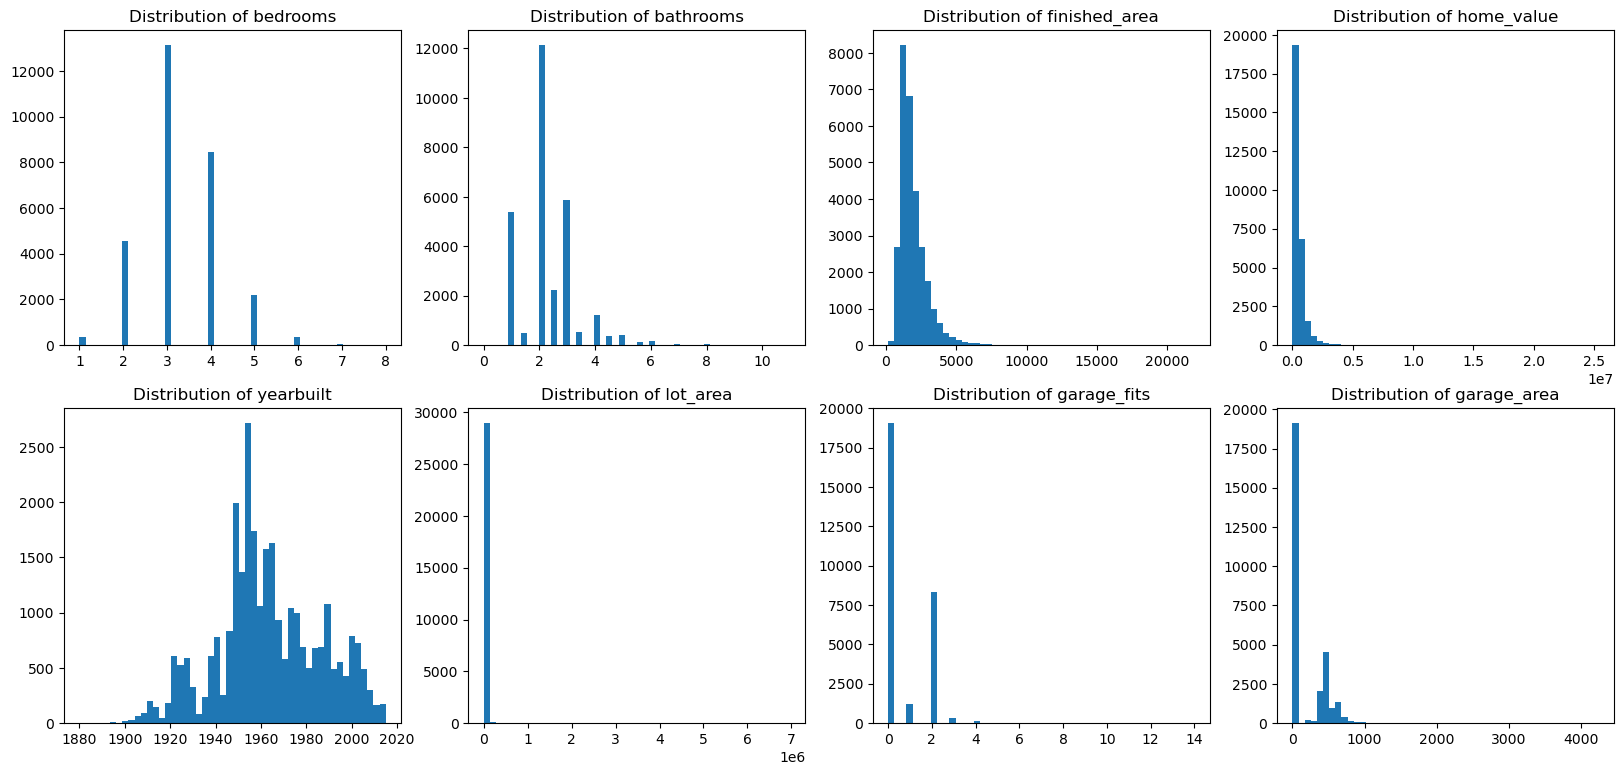

In [24]:
# visualize univariate distributions:
plt.figure(figsize=(20,9))
for i, col in enumerate(columns):
    subplot_num = i+1
    plt.subplot(2,4,subplot_num)
    plt.title(f'Distribution of {col}')
    train[col].hist(bins=50)
    plt.grid(False)
plt.show()

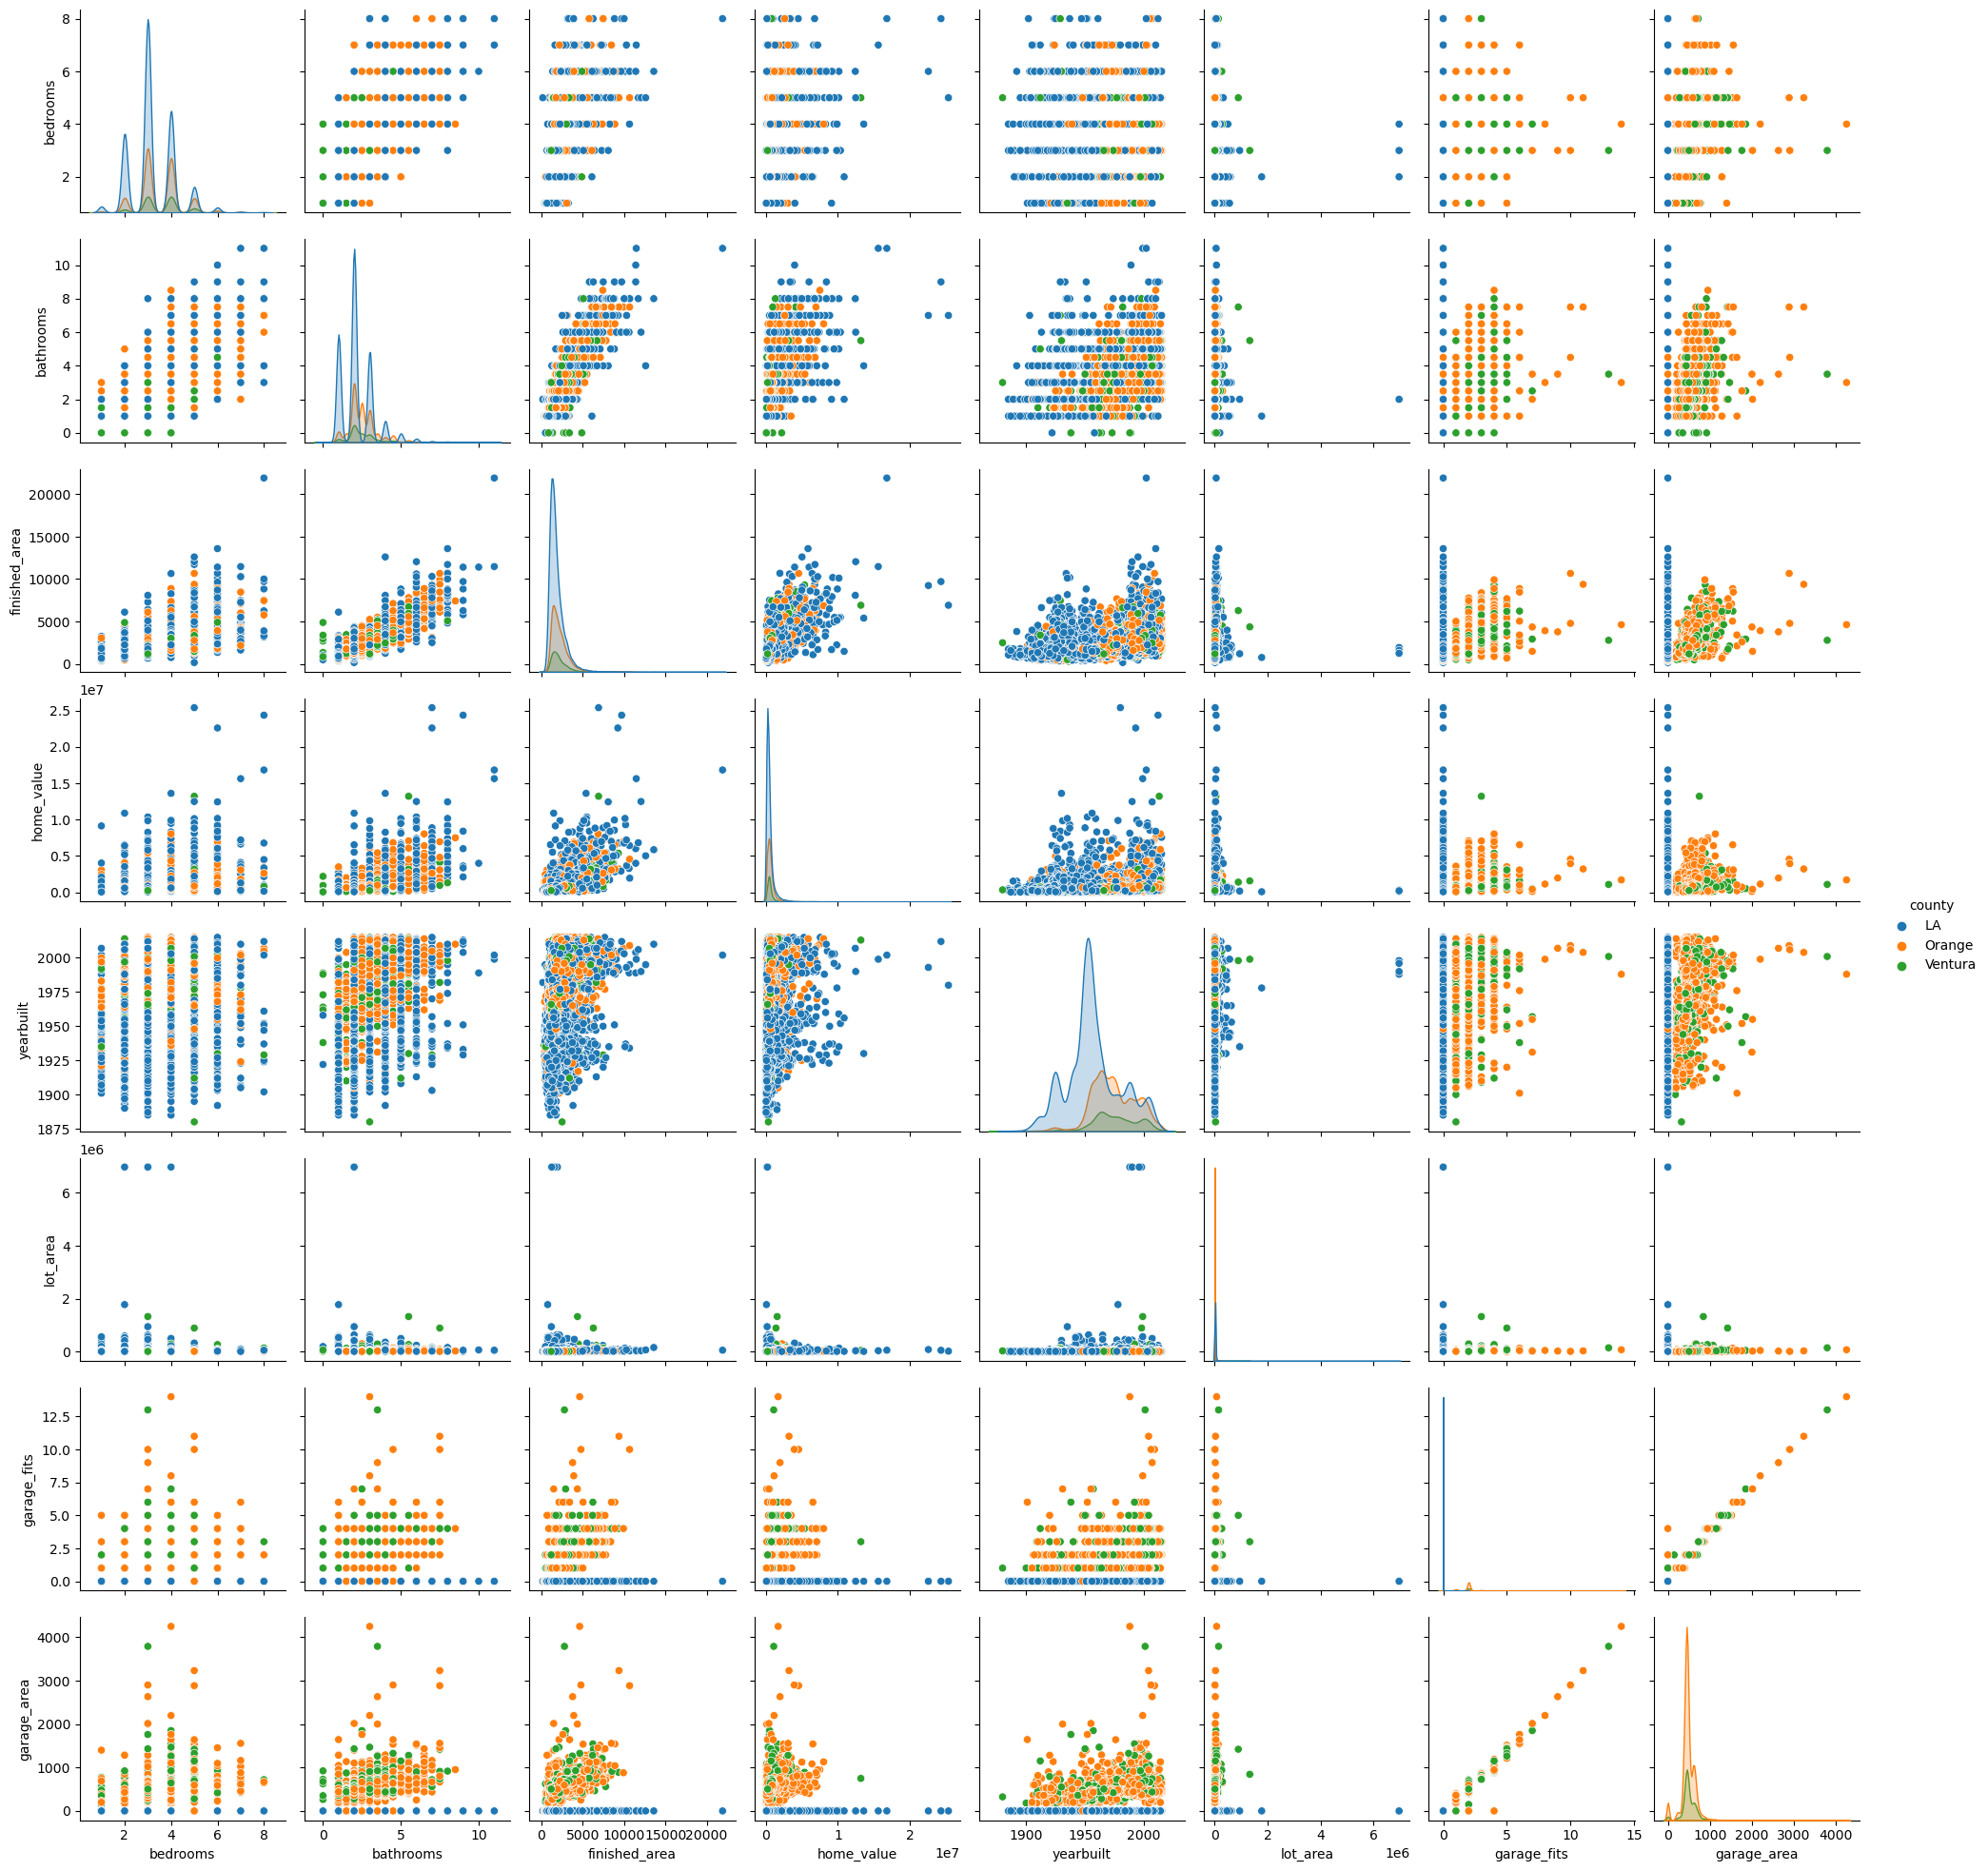

In [28]:
sns.pairplot(train, hue='county')

In [25]:
home_bed = pd.crosstab(df.bedrooms, df.home_value).T

<Axes: xlabel='home_value'>

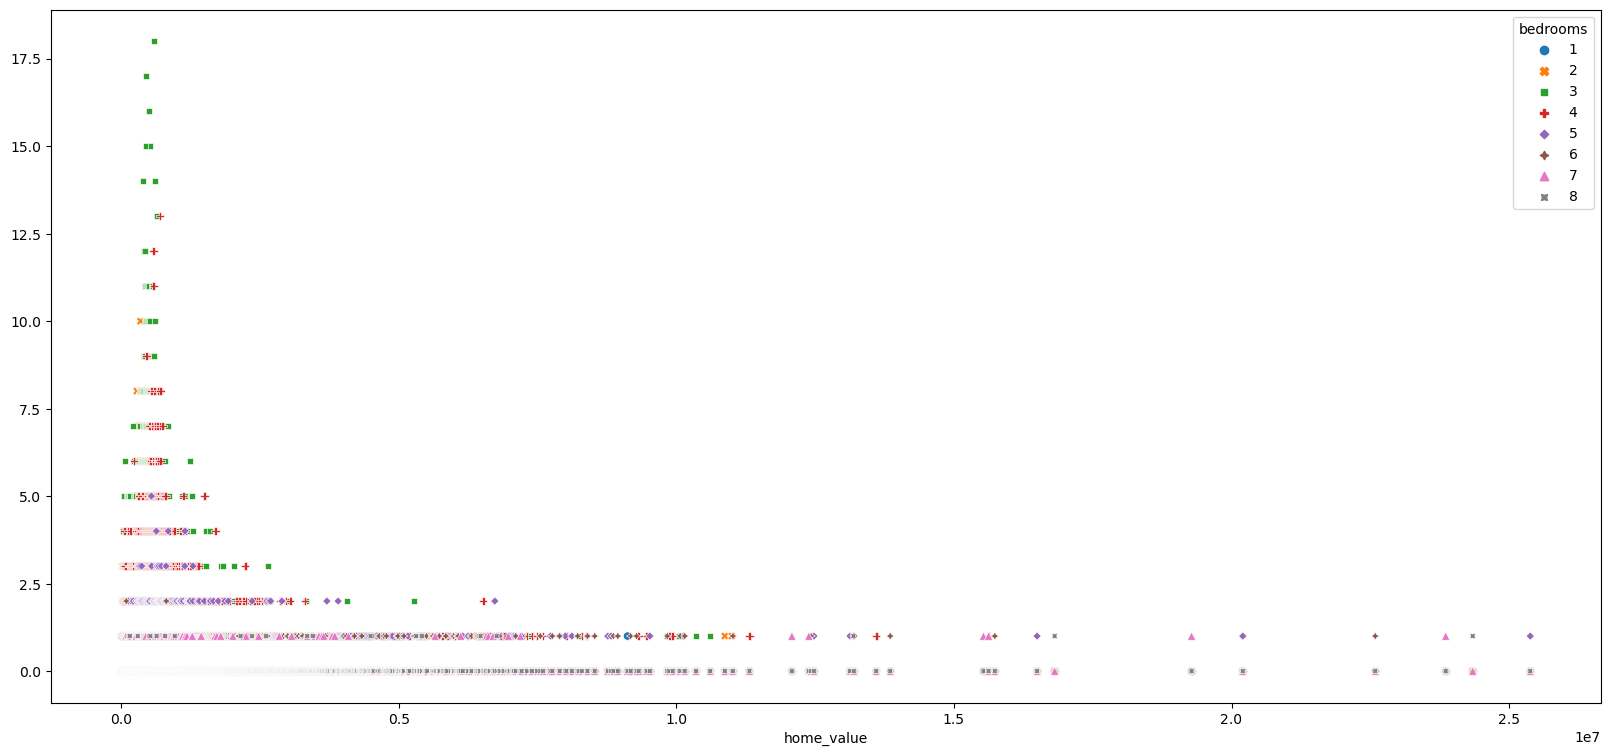

In [26]:
plt.figure(figsize=(20,9))
sns.scatterplot(home_bed)

# Does having a garage change the price?

### No garage data for LA county

In [30]:
pd.crosstab(train.county, train.garage_fits)

garage_fits,0,1,2,3,4,5,6,7,8,9,10,11,13,14
county,,,,,,,,,,,,,,
LA,18761,0,1,0,0,0,0,0,0,0,0,0,0,0
Orange,253,927,6325,231,90,14,6,2,1,1,2,1,0,1
Ventura,37,278,1973,102,44,7,2,1,0,0,0,0,1,0


Possible to make 3 separate models based on county?

In [31]:
train_noLA = train[train['county'] != 'LA']

In [32]:
train_noLA.head()

,bedrooms,bathrooms,finished_area,home_value,yearbuilt,lot_area,county,garage_fits,garage_area
13194,3,2.5,1280.0,415053.0,1989,3600.0,Orange,2,450.0
15653,5,2.5,1438.0,458000.0,1954,7210.0,Orange,1,390.0
8076,3,2.0,1438.0,511000.0,1973,6300.0,Ventura,2,441.0
20640,3,3.0,2601.0,497382.0,1994,7000.0,Orange,2,592.0
2508,3,1.5,1158.0,302395.0,1952,6754.0,Orange,1,360.0


In [45]:
import matplotlib as mpl
mpl.rcParams["axes.formatter.useoffset"] = False

(0.0, 5000000.0)

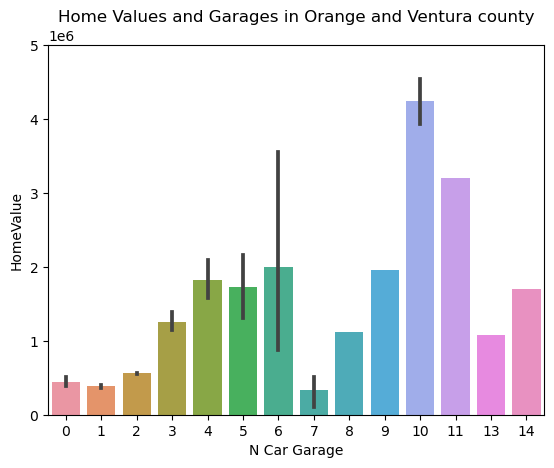

In [56]:
sns.barplot(train_noLA, x=train_noLA.garage_fits, y=train_noLA.home_value)
plt.title('Home Values and Garages in Orange and Ventura county')
plt.ylabel('HomeValue')
plt.xlabel('N Car Garage')
ax = plt.gca()

ax.set_ylim([0, 5000000])

<Axes: >

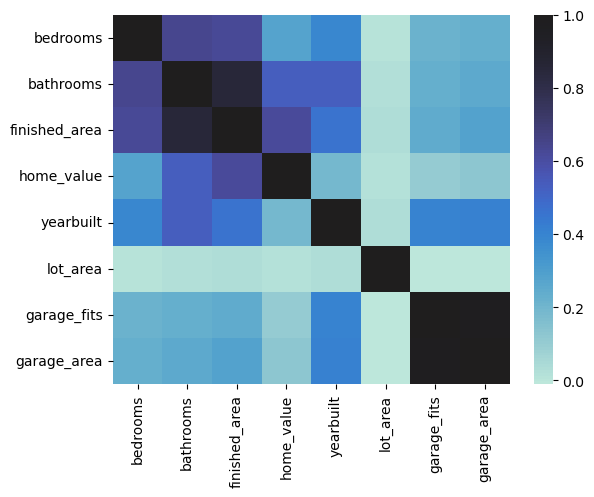

In [40]:
sns.heatmap(train.drop(columns='county').corr(), center=1)

So far teh best looking correlation for all counties is bedrooms, bathrooms, and finished area

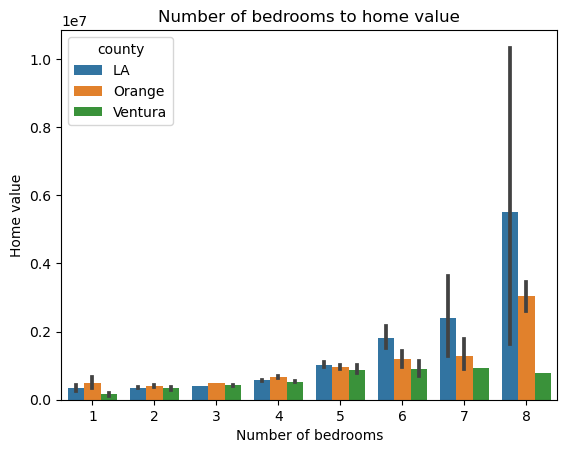

In [71]:
#plot our variables
sns.barplot(data=train, x=train.bedrooms, y=train.home_value, hue='county')
plt.title('Number of bedrooms to home value')
plt.xlabel('Number of bedrooms')
plt.ylabel('Home value')
plt.show()

<Axes: xlabel='bedrooms', ylabel='Count'>

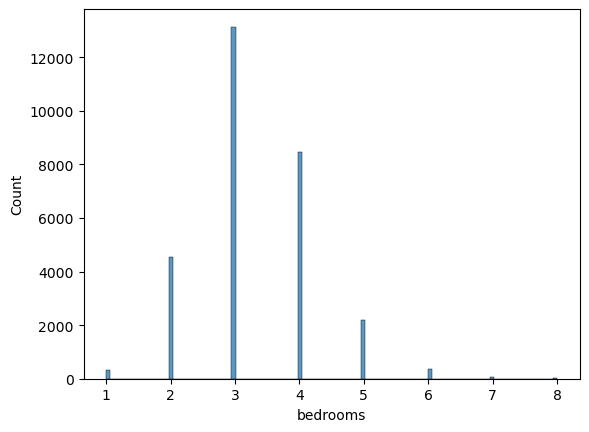

In [72]:
sns.histplot(train, x=train.bedrooms)

<Axes: title={'center': 'home_value'}, xlabel='bedrooms'>

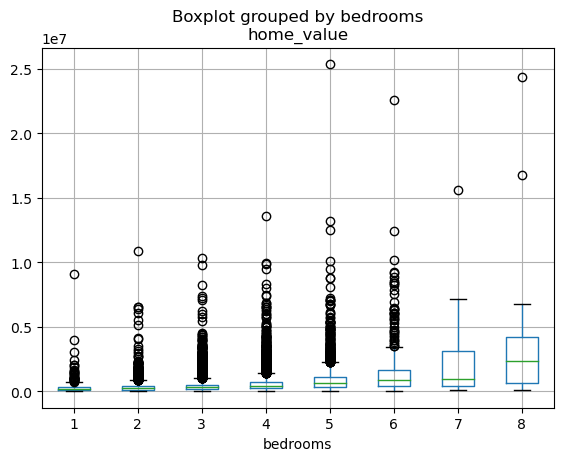

In [76]:
train.boxplot('home_value', by= 'bedrooms')

In [90]:
def catcont_four_graphs(df, var1, var2, hue):
    sns.barplot(data=df, x=df[var1], y=df[var2], hue=hue)
    plt.title(f'Number of {var1} to {var2}')
    plt.xlabel(f'Number of {var1}')
    plt.ylabel(f'{var2}')
    plt.show()
    print('~~~~~~~~~~~~~~~~~~~~~')
    sns.histplot(df, x=df[var1])
    plt.title(f'Count of {var1}')
    plt.xlabel(f'Number of {var1}')
   
    plt.show()
    print('~~~~~~~~~~~~~~~~~~~~~')
    sns.histplot(df, x=df[var2])
    plt.title(f'Count of {var2}')
    plt.xlabel(f'Number of {var2}')
   
    plt.show()
    print('~~~~~~~~~~~~~~~~~~~~~')
    train.boxplot(var2, by= var1)
    
    plt.xlabel(f'Number of {var1}')
    plt.ylabel(f'{var2}')
    plt.show()
    print('~~~~~~~~~~~~~~~~~~~~~')

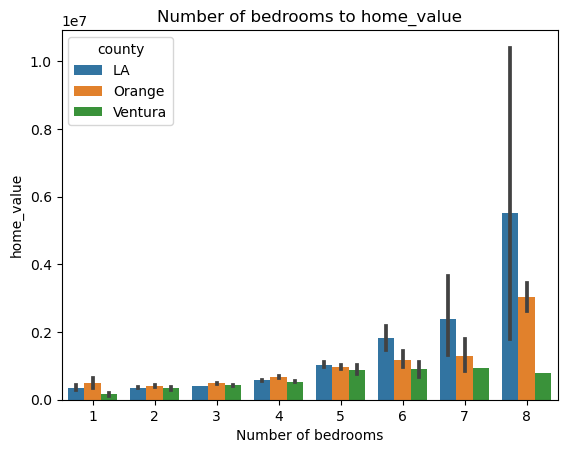

~~~~~~~~~~~~~~~~~~~~~


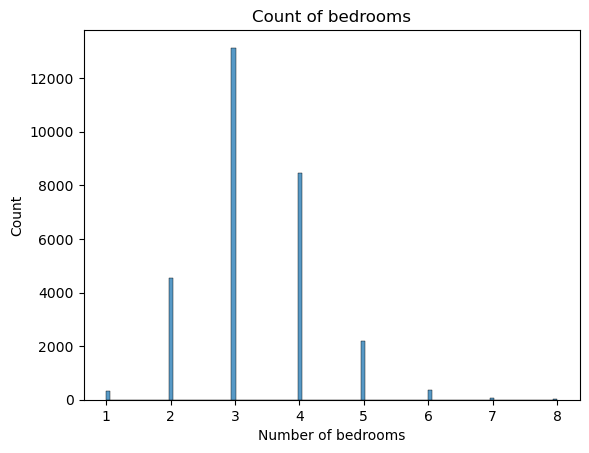

~~~~~~~~~~~~~~~~~~~~~


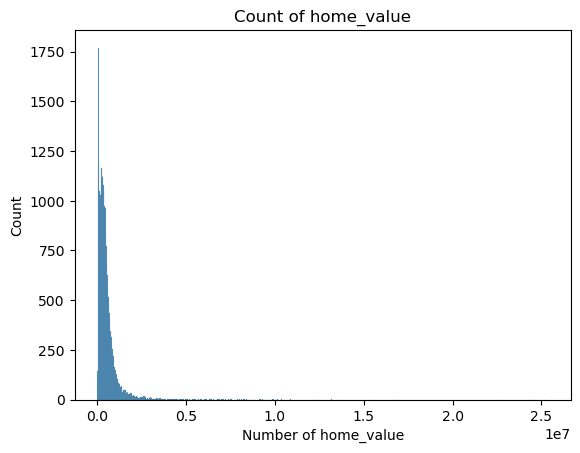

~~~~~~~~~~~~~~~~~~~~~


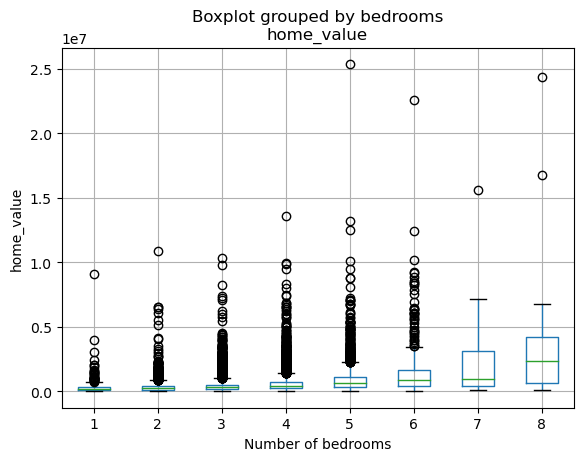

~~~~~~~~~~~~~~~~~~~~~


In [91]:
catcont_four_graphs(train, 'bedrooms', 'home_value', 'county')

Consider dropping bathrooms > 6

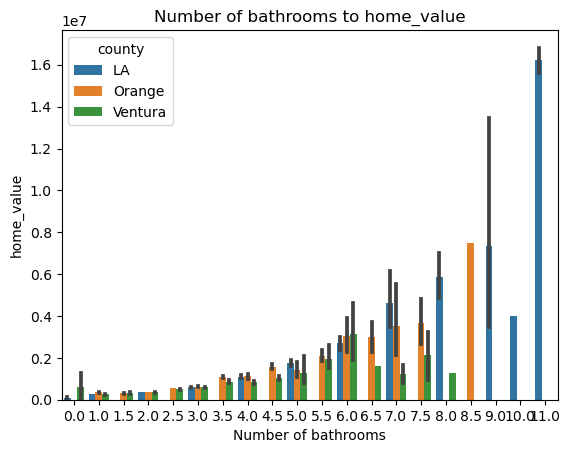

~~~~~~~~~~~~~~~~~~~~~


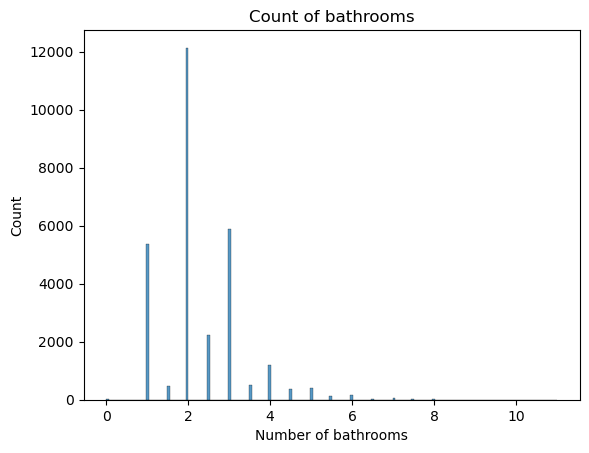

~~~~~~~~~~~~~~~~~~~~~


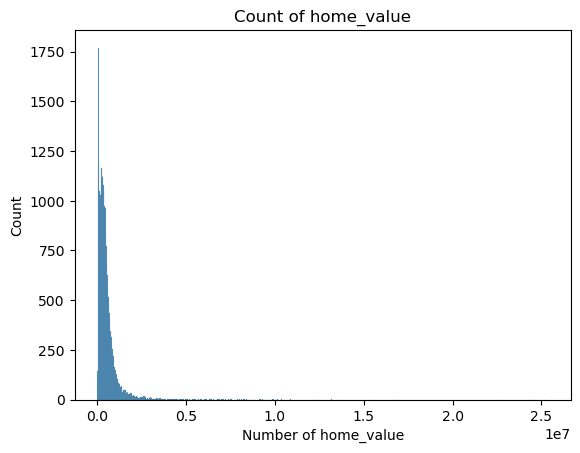

~~~~~~~~~~~~~~~~~~~~~


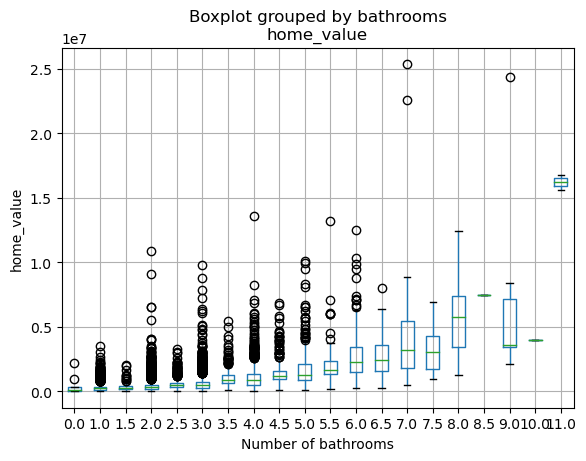

~~~~~~~~~~~~~~~~~~~~~


In [92]:
catcont_four_graphs(train, 'bathrooms', 'home_value', 'county')

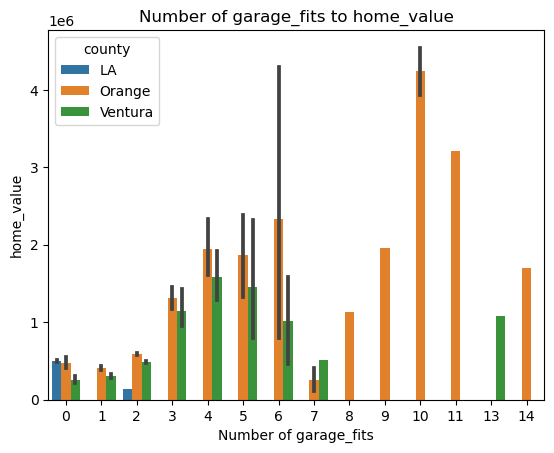

~~~~~~~~~~~~~~~~~~~~~


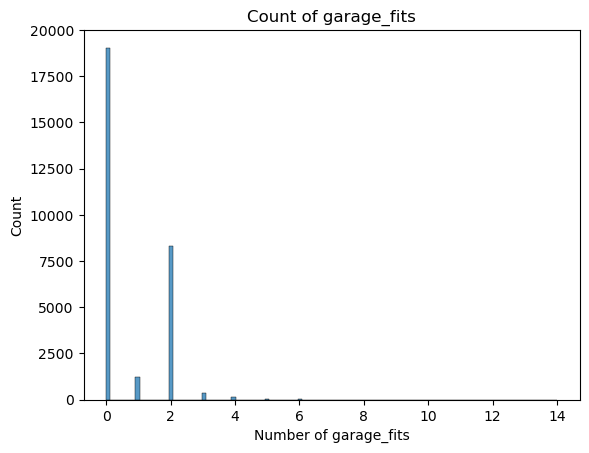

~~~~~~~~~~~~~~~~~~~~~


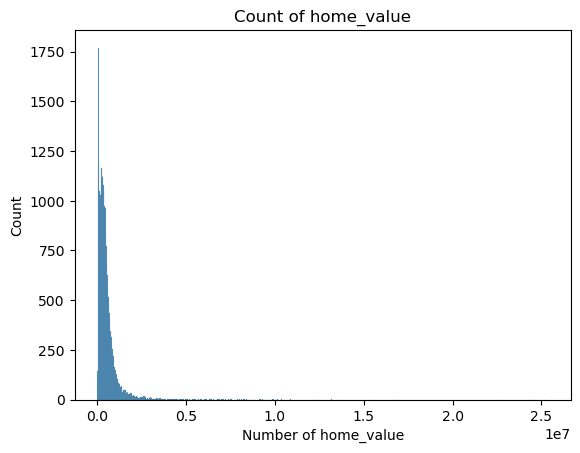

~~~~~~~~~~~~~~~~~~~~~


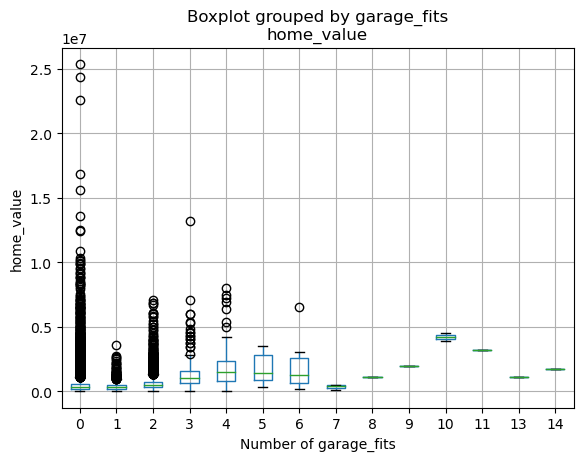

~~~~~~~~~~~~~~~~~~~~~


In [93]:
catcont_four_graphs(train, 'garage_fits', 'home_value', 'county')

In [73]:
import scipy.stats as stats

In [75]:
mean_home_value = train.home_value.mean()
mean_home_value

525466.0237775713

In [ ]:
# cat and cont
# need mann-whitney t test for bedrooms and home_value
alpha = .05
tstat, p = stats.mannwhitneyu()

In [57]:
check_columns(train)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
6,county,3,"[LA, Orange, Ventura]",0,0.0,object
0,bedrooms,8,"[2, 4, 3, 5, 1, 6, 7, 8]",0,0.0,int64
7,garage_fits,14,"[0, 2, 1, 3, 4, 6, 5, 14, 7, 10, 13, 11, 8, 9]",0,0.0,int64
1,bathrooms,20,"[1.0, 2.0, 2.5, 3.0, 4.0, 1.5, 3.5, 5.0, 4.5, ...",0,0.0,float64
4,yearbuilt,128,"[1965, 1968, 1989, 1910, 1951, 1949, 1950, 197...",0,0.0,int64
8,garage_area,716,"[0.0, 450.0, 390.0, 441.0, 592.0, 360.0, 632.0...",0,0.0,float64
2,finished_area,4082,"[884.0, 1628.0, 1280.0, 1656.0, 1103.0, 1400.0...",0,0.0,float64
5,lot_area,10685,"[2696.0, 12987.0, 3600.0, 6100.0, 5145.0, 6096...",0,0.0,float64
3,home_value,23467,"[139568.0, 299367.0, 415053.0, 569550.0, 41369...",0,0.0,float64


## All Counties

## for bathrooms bedrooms and finished area first

Lets get ready for some modeling

In [61]:
# Make Dummies
dummy_list = ['county']
dummy_df = pd.get_dummies(train[dummy_list], dtype=int, drop_first=True)
train_prepd = pd.concat([train, dummy_df], axis=1)

In [62]:
train_prepd.head()

,bedrooms,bathrooms,finished_area,home_value,yearbuilt,lot_area,county,garage_fits,garage_area,county_Orange,county_Ventura
13634,2,1.0,884.0,139568.0,1965,2696.0,LA,0,0.0,0,0
29240,4,2.0,1628.0,299367.0,1968,12987.0,LA,0,0.0,0,0
13194,3,2.5,1280.0,415053.0,1989,3600.0,Orange,2,450.0,1,0
47192,3,2.0,1656.0,569550.0,1910,6100.0,LA,0,0.0,0,0
5675,3,1.0,1103.0,41369.0,1951,5145.0,LA,0,0.0,0,0


I want Unscaled

In [63]:
# X and y splits to scale
target = "home_value"

X_train = train[['bedrooms', 'bathrooms', 'finished_area']]
y_train = train[target]

X_validate = validate[['bedrooms', 'bathrooms', 'finished_area']]
y_validate = validate[target]

X_test = test[['bedrooms', 'bathrooms', 'finished_area']]
y_test = test[target]

Now Scaled

In [64]:

X_train_scaled = train[['bedrooms', 'bathrooms', 'finished_area']]

X_validate_scaled = validate[['bedrooms', 'bathrooms', 'finished_area']]

X_test_scaled = test[['bedrooms', 'bathrooms', 'finished_area']]


### Modeling

Start with 'bedrooms', 'bathrooms', and 'finished_area'

### Delivery

Come back to this at after some time

![Screenshot 2023-09-07 at 9.36.29 AM.png](<attachment:Screenshot 2023-09-07 at 9.36.29 AM.png>)
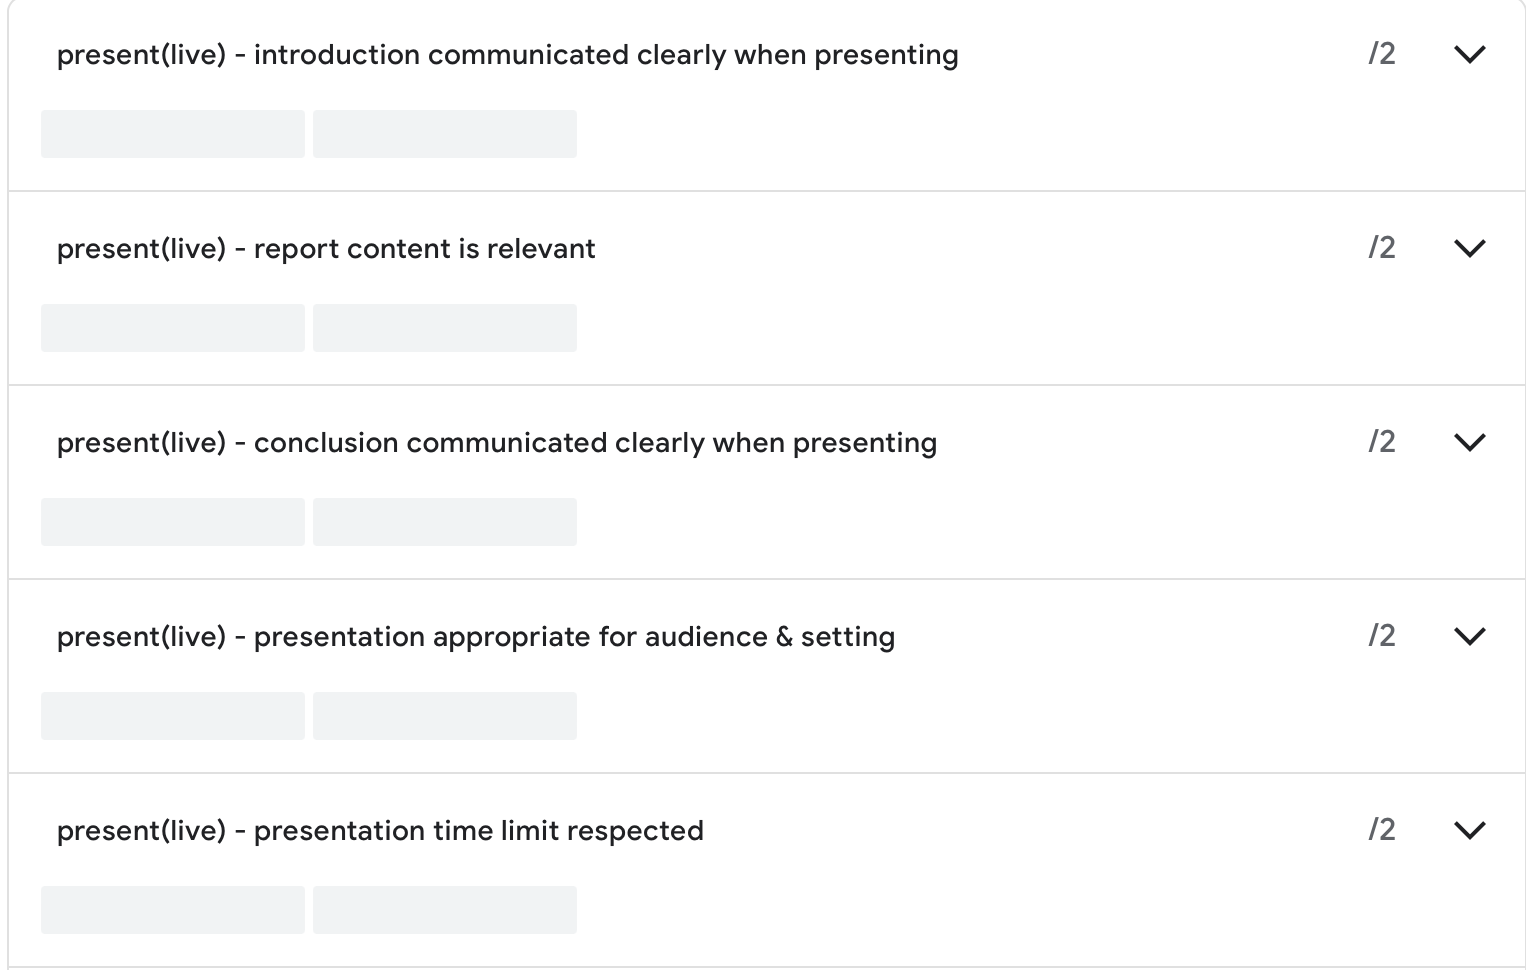